# Tarea 2 - Taller de Deep Learning

**Fecha de entrega: 24/11/2024**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN) en un problema de clasificación de secuencias. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos de electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [Heartbeat Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). Este dataset contiene señales de ECG segmentadas, donde cada segmento corresponde a un latido del corazón. Cada segmento ya está preprocesado y categorizado en una de las siguientes clases:

- **N**: Normal (0)
- **S**: Arritmia supraventricular (1)
- **V**: Arritmia ventricular (2)
- **F**: Latido fusionado (3)
- **Q**: Latido desconocido (4)

Los archivos del dataset que deben utilizar son:

- **mitbih_train.csv**: Datos de entrenamiento.
- **mitbih_test.csv**: Datos de prueba.

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema, así como las técnicas y herramientas que quieran usar. Se recomienda el uso de Google Colab para simplificar el acceso a recursos de GPU, aunque pueden trabajar en sus propias máquinas si lo prefieren. La entrega debe realizarse en formato .ipynb (Jupyter Notebook).

**Restricciones**

- No se permite utilizar modelos pre-entrenados; cada modelo debe ser implementado desde cero.
- Deben utilizar al menos un modelo basado en RNN (por ejemplo, LSTM o GRU).
- Es necesario realizar un **análisis exploratorio de los datos**, que incluya una descripción de las señales ECG, el balanceo de clases y cualquier limpieza o transformación necesaria de los datos.
- Las decisiones sobre el preprocesamiento de las señales (como normalización, segmentación, etc.) deben estar fundamentadas en una exploración inicial del dataset y explicadas en el notebook.

**Reporte**

Se requiere que reporten las siguientes métricas: accuracy, precision, recall y F1-score para la evaluación del modelo. Además, se espera ver una evolución clara del modelo durante el entrenamiento, que incluya logs y gráficas de las métricas tanto para los datos de entrenamiento como de validación.

**Evidencia de Experimentos**

Deben proporcionar evidencia de la ejecución de experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:

- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

Comenzamos con la descarga e instalación de librerías y dependencias necesarias.

In [1]:
!pip install torch torchinfo torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.datasets as datasets

from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import matplotlib.pyplot as plt

import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)

import numpy as np

import sys
import platform

from tqdm.notebook import tqdm_notebook

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
)

Comenzamos con la descarga del dataset, y el análisis exploratorio

In [3]:
!mkdir data
!curl -L -o ./data/archive.zip https://www.kaggle.com/api/v1/datasets/download/shayanfazeli/heartbeat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 98.8M  100 98.8M    0     0  15.3M      0  0:00:06  0:00:06 --:--:-- 21.7M


In [4]:
!unzip ./data/archive.zip -d ./data > /dev/null 2>&1

In [5]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

NUM_WORKERS = max(os.cpu_count() - 1, 1)
BATCH_SIZE = 256  # tamaño del batch

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: cuda
Num Workers: 11


Comenzamos con la carga de los datos, y el análisis exploratorio

In [6]:
TRAIN_DATA_PATH = "./data/mitbih_train.csv"
TEST_DATA_PATH = "./data/mitbih_test.csv"

df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

# Restamos 1 ya que la última columna representa
# la clasificación.
ninputs = df.shape[1] - 1

# Para contar las clases, nos quedamos con la última columna de los datos
# y contamos los valores únicos.
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")


Existen 5 clases y 187 características


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: xlabel='187'>

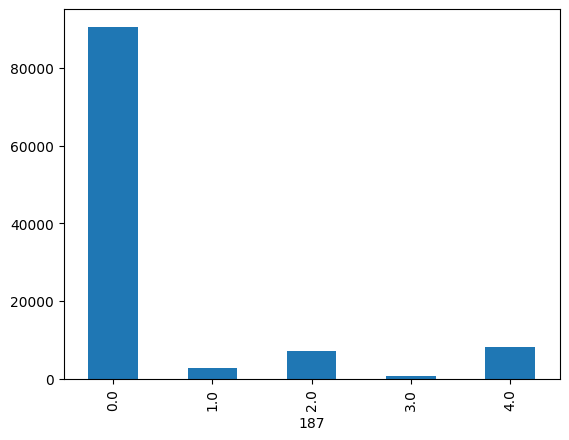

In [7]:
df_test.info()
df_test.head()

X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar")

Como se puede observar, existe un gran desbalanceo en la información,
teniendo una gran cantidad de datos cuya clasificación es "0".

Analizaremos de forma cualitativa los datos. Comenzaremos por visualizar los datos,
qué representan, los valores máximos y mínimos, y cómo se distribuyen.

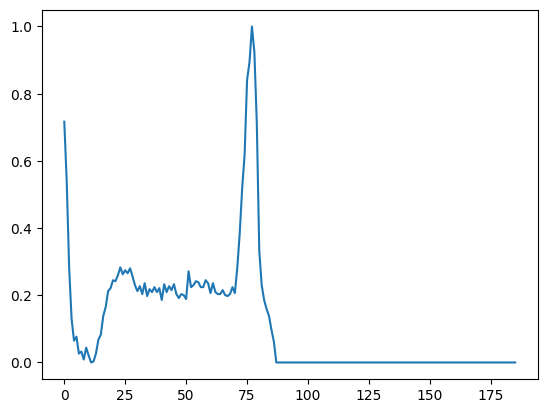

In [8]:
# Visualizamos una muestra del dato
plt.plot(X_train.iloc[7, :-1])
plt.show()

Como se puede observar en la gráfica inicial de una muestra,
el ECG muestra valores 0.0 para cuando no hay dato.

Verifiquemos, cuál es el largo de las secuencias, y qué
frecuencia relativa tienen a través de un histograma.

In [9]:
excluded_values = [0.0] # Excluímos lo que será nuestro "padding"
row_lengths_train = df_train[:-1].apply(lambda row: sum(~row.isin(excluded_values)), axis=1)
row_lengths_test = df_test[:-1].apply(lambda row: sum(~row.isin(excluded_values)), axis=1)

print("\nMínimo largo de las secuencias para datos de entrenamiento:")
print(row_lengths_train.min())
print("\nMáximo largo de las secuencias para datos de entrenamiento:")
print(row_lengths_test.max())


Mínimo largo de las secuencias para datos de entrenamiento:
15

Máximo largo de las secuencias para datos de entrenamiento:
188


Media: 110.7916119379119
Desviación estándar: 27.469357677739158


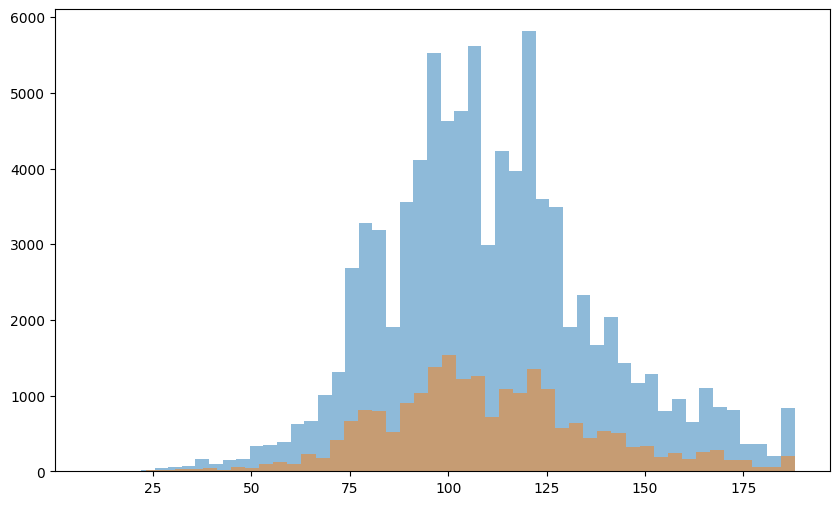

In [10]:
from scipy.stats import norm

mu, std = norm.fit(row_lengths_train)
print(f"Media: {mu}")
print(f"Desviación estándar: {std}")

plt.figure(figsize=(10, 6))
plt.hist(row_lengths_train, bins=50, alpha=0.5, label="Train")
plt.hist(row_lengths_test, bins=50, alpha=0.5, label="Test")
plt.show()

A partir de la gráfica, podría inferirse una distribución casi "Gaussiana". Evaluaremos más adelante, si sólo tomar las muestras cuyo largo de
secuencias sea representativo entre la media +- la desviación
estandar.

Definimos a continuación un par de función que nos serán de utilidad más adelante, para cuando realicemos "data augmentation", en donde
aplicaremos "ruido" a la señal, para aumentar
la cantidad de datos en aquellas clases
con menor cantidad de datos.

In [35]:
# Dada una secuencia, se aplica de forma randómica "ruido".
def aplicar_ruido(sec, nivel_ruido=0.01):

    # Decidimos la operacia realizar sobre la secuencia

    # operador = np.random.randint(-1, 1)

    secuencia_modificada = [s + np.random.uniform(0,nivel_ruido) for s in sec]

    # Luego, "clipeamos" los valores para que estén entre 0 y 1
    # que son los valores máximo y mínimo que pueden
    # tomar las secuencias.

    secuencia_modificada = np.clip(secuencia_modificada, 0, 1)

    # Agregamos el último valor de la secuencia para que se corresponda
    # con la clase correcta y retornamos

    secuencia_modificada[-1] = sec.iloc[-1]

    return pd.Series(secuencia_modificada)

In [12]:
# Dado un conjunto de secuencias, se incorporan nuevos datos
# aplicándose ruido a la secuencia original.
def aplicar_ruido_a_conjunto(conjunto, nivel_ruido=0.01, cantidad_datos=1000):

    nuevo_dataset = conjunto.copy()

    for idx in tqdm_notebook(np.random.randint(0, len(conjunto), cantidad_datos)):
        # Obtenemos una secuencia del conjunto de forma
        # aleatoria.
        secuencia = conjunto.iloc[idx]

        # Aplicamos ruido a la secuencia.

        secuencia_modificada = aplicar_ruido(secuencia, nivel_ruido)


        # Agregamos la secuencia modificada al nuevo dataset.
        nuevo_dataset.loc[len(nuevo_dataset)] = secuencia_modificada

    return nuevo_dataset

Obtendremos los pesos relativos de cada clase, de manera que nos sirva más adelante para considerar éstos al momento del cálculo del error, ponderando
el peso según la clase.

In [13]:
# Obtenemos los pesos relativos de cada clase
class_weights = df_train.iloc[:, -1].value_counts()

# Obtenemos la totalidad de los datos
total_count = len(df_train)

print(f"La distribución es :", class_weights)

La distribución es : 187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


En primera instancia, no vamos a considerar el desbalanceo de los datos, y entrenaremos el modelo con este desbalanceo.

# Definir dataloader


Vamos a definir una clase dataset customizada, y posteriormente, creamos una función
"get_dataloaders" para obtener los dataloaders.

In [14]:
class ECGDataSet(Dataset):
    def __init__(self, x_features, y_features, num_classes):
        self.x_df = x_features.values
        self.y_df = y_features.values
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [15]:
# Vamos a mantener la misma proporción de las clases, en la obtención
# de los datos para validación.
X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

train_dataset = ECGDataSet(X_train_stratified, y_train_stratified, nclasses)
val_dataset = ECGDataSet(X_val_stratified, y_val_stratified, nclasses)
test_dataset = ECGDataSet(X_test, y_test, nclasses)

def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [16]:
# Definimos algunas variables
HIDDEN_SIZE = 512
BATCH_SIZE = 128
INPUT_SIZE = 187 # Largo de las secuencias

# Definimos los dataloaders
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE)

In [17]:
# Probamos el dataloader

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader))
print(x_batch.shape, y_batch.shape)

torch.Size([128, 187]) torch.Size([128])


Definimos un modelo inicial de RNN con LSTM, de 3 capas y probamos su performance.

In [18]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hidden, _) = self.rnn(x)
        # _, hidden = self.rnn(x)
        out = self.fc(hidden[-1])
        return out

summary(
    RNNModel(INPUT_SIZE, HIDDEN_SIZE, nclasses),
    input_size=(BATCH_SIZE, INPUT_SIZE),
    dtypes=[torch.float32],
)

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 [128, 5]                  --
├─LSTM: 1-1                              [128, 1, 512]             5,638,144
├─Linear: 1-2                            [128, 5]                  2,565
Total params: 5,640,709
Trainable params: 5,640,709
Non-trainable params: 0
Total mult-adds (M): 722.01
Input size (MB): 0.10
Forward/backward pass size (MB): 0.53
Params size (MB): 22.56
Estimated Total Size (MB): 23.19

In [19]:
rnn_model = RNNModel(
    input_size=INPUT_SIZE   , hidden_size=HIDDEN_SIZE, num_classes=nclasses
).to(DEVICE)

rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.0001)
# CRITERION = nn.BCELoss().to(DEVICE)
CRITERION = nn.CrossEntropyLoss()

_, _ = train(
    rnn_model,
    optimizer=rnn_optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=10,
)

Epoch: 001 | Train Loss: 0.72048 | Val Loss: 0.54322
Epoch: 002 | Train Loss: 0.45649 | Val Loss: 0.40383
Epoch: 003 | Train Loss: 0.38574 | Val Loss: 0.35857
Epoch: 004 | Train Loss: 0.34706 | Val Loss: 0.32402
Epoch: 005 | Train Loss: 0.31520 | Val Loss: 0.29724
Epoch: 006 | Train Loss: 0.28662 | Val Loss: 0.26327
Epoch: 007 | Train Loss: 0.25278 | Val Loss: 0.22993
Epoch: 008 | Train Loss: 0.22474 | Val Loss: 0.21101
Epoch: 009 | Train Loss: 0.20480 | Val Loss: 0.19694
Epoch: 010 | Train Loss: 0.19291 | Val Loss: 0.19360


Evaluemos ahora la performance del modelo

In [20]:
model_calassification_report(rnn_model, test_loader, DEVICE, nclasses)

Accuracy: 0.9499

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     18118
           1       0.86      0.50      0.63       556
           2       0.85      0.81      0.83      1448
           3       0.43      0.23      0.30       162
           4       0.97      0.89      0.92      1608

    accuracy                           0.95     21892
   macro avg       0.81      0.68      0.73     21892
weighted avg       0.95      0.95      0.95     21892



Ahora, procedemos a balancear las clases, habiendo obtenido por cada una el total necesario
para balancearlas. Aplicaremos "data augmentation" aplicando ruido a las demás clases (las distintas a "0.0") y evaluaremos nuevamente el resultado del
modelo.


In [24]:
def balancear_datasets(dataset, ignore_class=0.0, nivel_ruido=0.01):
    # Creamos un nuevo dataset
    nuevo_dataset = dataset.copy()

    # Obtenemos los pesos relativos de cada clase
    class_weights = dataset.iloc[:, -1].value_counts()

    # Calculamos la cantidad de datos que deberíamos tener
    # para cada clase.
    # Obtenemos el valor de la clase mayoritaria
    max_class = class_weights.max()

    # Calculamos los valores adicionales necesarios
    # por cada clase, excepto la mayoritaria.
    class_counts = (max_class) - round((class_weights.iloc[1:]))

    # Para cada clase, generamos datos adicionales
    for clase, cantidad in class_counts.items():
        print(f"Procesando clase: ",clase)
        print(f"Cantidad de muestras a incluir: ", cantidad)
        # Obtenemos los datos de la clase
        datos_clase = dataset[dataset.iloc[:, -1] == clase]
        print(f"Distribución de datos: ", datos_clase.iloc[:, -1].value_counts())

        # Generamos datos adicionales
        #datos_adicionales = aplicar_ruido_a_conjunto(datos_clase, nivel_ruido, cantidad_datos=class_counts[clase])
        datos_adicionales = aplicar_ruido_a_conjunto(datos_clase, nivel_ruido, cantidad_datos=10000)
        print(f"Distribución de datos adicionales: ", datos_adicionales.iloc[:, -1].value_counts())

        # Agregamos los datos adicionales al nuevo dataset
        nuevo_dataset = pd.concat([nuevo_dataset, datos_adicionales], axis=0)

    return nuevo_dataset

In [31]:
def balancear_dataset_clase(dataset, clase, nivel_ruido=0.01, cantidad_datos=100):
    # Creamos un nuevo dataset
    nuevo_dataset = dataset.copy()

    # Obtenemos los datos de la clase
    datos_clase = dataset[dataset.iloc[:, -1] == clase]

    datos_adicionales = aplicar_ruido_a_conjunto(datos_clase, nivel_ruido, cantidad_datos)

    # Agregamos los datos adicionales al nuevo dataset
    nuevo_dataset = pd.concat([nuevo_dataset, datos_adicionales], axis=0)

    return nuevo_dataset

In [25]:
df_train_balanceado = balancear_datasets(df_train, nivel_ruido=0.01)

Procesando clase:  4.0
Cantidad de muestras a incluir:  66040
Distribución de datos:  187
4.0    6431
Name: count, dtype: int64


  0%|          | 0/10000 [00:00<?, ?it/s]

Distribución de datos adicionales:  187
1.0    10000
4.0     6431
Name: count, dtype: int64
Procesando clase:  2.0
Cantidad de muestras a incluir:  66683
Distribución de datos:  187
2.0    5788
Name: count, dtype: int64


  0%|          | 0/10000 [00:00<?, ?it/s]

Distribución de datos adicionales:  187
1.0    10000
2.0     5788
Name: count, dtype: int64
Procesando clase:  1.0
Cantidad de muestras a incluir:  70248
Distribución de datos:  187
1.0    2223
Name: count, dtype: int64


  0%|          | 0/10000 [00:00<?, ?it/s]

Distribución de datos adicionales:  187
1.0    12223
Name: count, dtype: int64
Procesando clase:  3.0
Cantidad de muestras a incluir:  71830
Distribución de datos:  187
3.0    641
Name: count, dtype: int64


  0%|          | 0/10000 [00:00<?, ?it/s]

Distribución de datos adicionales:  187
1.0    10000
3.0      641
Name: count, dtype: int64


Analizamos nuevamente el status de los datos, para verificar si la aplicación
de "data augmentation" incrementó la cantidad. El efecto de ésta técnica,
sobre la "calidad" del modelo, se evaluará posteriormente.

187
0.0    72471
1.0    44446
4.0    12862
2.0    11576
3.0     1282
Name: count, dtype: int64


<Axes: xlabel='187'>

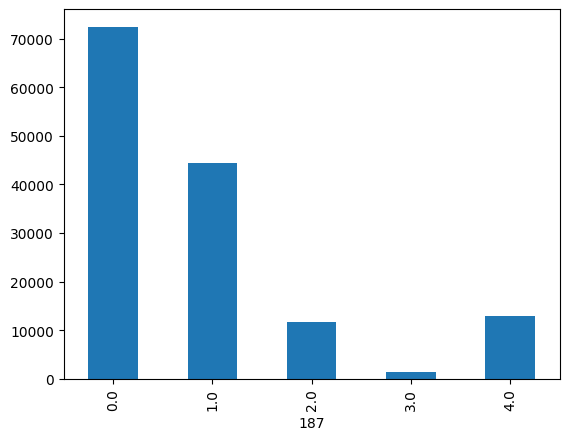

In [26]:
class_count = df_train_balanceado.iloc[:, -1].value_counts()
print(class_count)
class_count.sort_index().plot(kind="bar")

Volvamos a generar los datasets, y volver a entrenar al modelo, pero ésta vez con los datos "augmentados".

In [27]:
X_train_stratified_a, X_val_stratified_a, y_train_stratified_a, y_val_stratified_a = train_test_split(df_train_balanceado.iloc[:,:-1], df_train_balanceado.iloc[:,-1], test_size=0.2, stratify=df_train_balanceado.iloc[:,-1], random_state=42)

train_dataset_a = ECGDataSet(X_train_stratified_a, y_train_stratified_a, nclasses)
val_dataset_a = ECGDataSet(X_val_stratified_a, y_val_stratified_a, nclasses)
test_dataset_a = ECGDataSet(X_test, y_test, nclasses)

def get_data_loaders_a(batch_size):

    train_loader = DataLoader(
        train_dataset_a, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset_a, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset_a, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [28]:
train_loader_a, val_loader_a, test_loader_a = get_data_loaders_a(BATCH_SIZE)

In [29]:
rnn_model_a = RNNModel(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_classes=nclasses
).to(DEVICE)

rnn_optimizer = optim.Adam(rnn_model_a.parameters(), lr=0.0001)
CRITERION = nn.CrossEntropyLoss()

_, _ = train(
    rnn_model_a,
    optimizer=rnn_optimizer,
    criterion=CRITERION,
    train_loader=train_loader_a,
    val_loader=val_loader_a,
    device=DEVICE,
    do_early_stopping=False,
    epochs=10,
)

Epoch: 001 | Train Loss: 1.02491 | Val Loss: 0.85311
Epoch: 002 | Train Loss: 0.78651 | Val Loss: 0.72228
Epoch: 003 | Train Loss: 0.63903 | Val Loss: 0.53490
Epoch: 004 | Train Loss: 0.42036 | Val Loss: 0.33328
Epoch: 005 | Train Loss: 0.30519 | Val Loss: 0.27515
Epoch: 006 | Train Loss: 0.26101 | Val Loss: 0.24324
Epoch: 007 | Train Loss: 0.23253 | Val Loss: 0.21720
Epoch: 008 | Train Loss: 0.21254 | Val Loss: 0.21184
Epoch: 009 | Train Loss: 0.19872 | Val Loss: 0.19376
Epoch: 010 | Train Loss: 0.18812 | Val Loss: 0.18335


In [30]:
model_calassification_report(rnn_model_a, test_loader_a, DEVICE, nclasses)

Accuracy: 0.9410

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18118
           1       0.49      0.62      0.55       556
           2       0.80      0.74      0.77      1448
           3       0.52      0.49      0.51       162
           4       0.97      0.90      0.94      1608

    accuracy                           0.94     21892
   macro avg       0.75      0.75      0.75     21892
weighted avg       0.94      0.94      0.94     21892



Como puede observarse, existe una mejora para la clase 3 (inicialmente tenía un f1-score de 0.3, y ascendió a 0.51); sin embargo, para la clase 1, se observa
una disminución de su f1-score (pasó de 0.63, a 0.55).

Probaremos entonces, aplicar data agumentation en algunas clases.

In [55]:
df_train_balanceado = balancear_dataset_clase(df_train,3,0.001,30000)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [56]:
df_train_balanceado = balancear_dataset_clase(df_train_balanceado,2,0.01,15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [57]:
df_train_balanceado = balancear_dataset_clase(df_train_balanceado,4,0.01,14000)

  0%|          | 0/14000 [00:00<?, ?it/s]

In [58]:
df_train_balanceado = balancear_dataset_clase(df_train_balanceado,1,0.01,18000)

  0%|          | 0/18000 [00:00<?, ?it/s]

187
0.0    72471
3.0    31282
4.0    26862
2.0    26576
1.0    22446
Name: count, dtype: int64


<Axes: xlabel='187'>

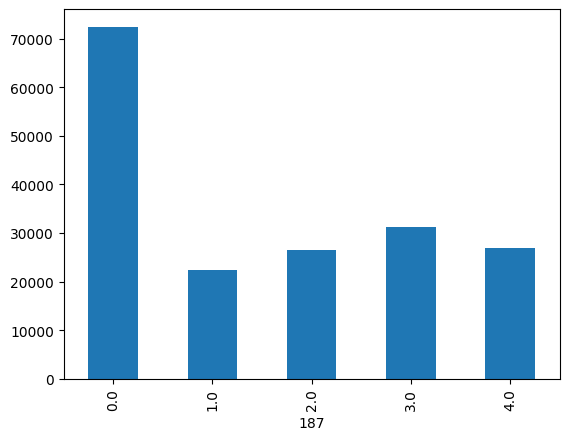

In [59]:
class_count = df_train_balanceado.iloc[:, -1].value_counts()
print(class_count)
class_count.sort_index().plot(kind="bar")

In [60]:
X_train_stratified_a, X_val_stratified_a, y_train_stratified_a, y_val_stratified_a = train_test_split(df_train_balanceado.iloc[:,:-1], df_train_balanceado.iloc[:,-1], test_size=0.2, stratify=df_train_balanceado.iloc[:,-1], random_state=42)

train_dataset_a = ECGDataSet(X_train_stratified_a, y_train_stratified_a, nclasses)
val_dataset_a = ECGDataSet(X_val_stratified_a, y_val_stratified_a, nclasses)
test_dataset_a = ECGDataSet(X_test, y_test, nclasses)

In [61]:
train_loader_a, val_loader_a, test_loader_a = get_data_loaders_a(BATCH_SIZE)

In [62]:
rnn_model_a = RNNModel(
    input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_classes=nclasses
).to(DEVICE)

rnn_optimizer = optim.Adam(rnn_model_a.parameters(), lr=0.0001)
CRITERION = nn.CrossEntropyLoss()

_, _ = train(
    rnn_model_a,
    optimizer=rnn_optimizer,
    criterion=CRITERION,
    train_loader=train_loader_a,
    val_loader=val_loader_a,
    device=DEVICE,
    do_early_stopping=False,
    epochs=15,
)

Epoch: 001 | Train Loss: 0.84534 | Val Loss: 0.60352
Epoch: 002 | Train Loss: 0.53545 | Val Loss: 0.47301
Epoch: 003 | Train Loss: 0.43024 | Val Loss: 0.39369
Epoch: 004 | Train Loss: 0.36167 | Val Loss: 0.34197
Epoch: 005 | Train Loss: 0.30744 | Val Loss: 0.28983
Epoch: 006 | Train Loss: 0.26965 | Val Loss: 0.26187
Epoch: 007 | Train Loss: 0.24422 | Val Loss: 0.23602
Epoch: 008 | Train Loss: 0.22367 | Val Loss: 0.21090
Epoch: 009 | Train Loss: 0.20694 | Val Loss: 0.19978
Epoch: 010 | Train Loss: 0.19137 | Val Loss: 0.20074
Epoch: 011 | Train Loss: 0.17809 | Val Loss: 0.18106
Epoch: 012 | Train Loss: 0.16190 | Val Loss: 0.16605
Epoch: 013 | Train Loss: 0.15044 | Val Loss: 0.19695
Epoch: 014 | Train Loss: 0.13833 | Val Loss: 0.13195
Epoch: 015 | Train Loss: 0.12922 | Val Loss: 0.12895


In [63]:
model_calassification_report(rnn_model_a, test_loader_a, DEVICE, nclasses)

Accuracy: 0.9571

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18118
           1       0.83      0.58      0.68       556
           2       0.89      0.86      0.87      1448
           3       0.34      0.80      0.48       162
           4       0.95      0.95      0.95      1608

    accuracy                           0.96     21892
   macro avg       0.80      0.83      0.79     21892
weighted avg       0.96      0.96      0.96     21892



Como se puede observar, existen mejoras en las clases. Si bien existe un accuracy general bueno, se observa que el f1-score por clase, -como por ejemplo-
para la clase 3, no es "bueno".

Se procede a entrenar el modelo, mediante Weight and Biases, utilizando el dataset con un mejor "balance".

In [64]:
!pip install wandb
import wandb

In [65]:
# Nos logueamos en Wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [66]:
# Definimos función de logueo para Wandb
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

In [67]:
WANDB_TEAM_NAME = "goterov-universidad-ort-uruguay"
WANDB_PROJECT = "entrega02"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "entrega02",
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.001, "min": 0.00001},
        "num_layers": {"values": [3, 5, 7]},  # Capas de la red LSTM
        "batch_size": {"values": [32, 256, 1024, 4096]},
        "hidden_size": {"values": [64, 128, 256, 512, 1024]}, # Número de capas convolucionales
        "optimizer": {"values": ["adam", "sgd"]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: zp7h4p87
Sweep URL: https://wandb.ai/goterov-universidad-ort-uruguay/entrega02/sweeps/zp7h4p87


In [70]:
def get_data_loaders_for_wandab(batch_size, num_workers=NUM_WORKERS):

    train_loader = DataLoader(
        train_dataset_a, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset_a, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset_a, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

In [71]:
class DynamicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DynamicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hidden, _) = self.rnn(x)
        # _, hidden = self.rnn(x)
        out = self.fc(hidden[-1])
        return out

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_batch_size = config.batch_size
    run_num_layers = config.num_layers
    run_hidden_size = config.hidden_size

    model = DynamicRNN(
        INPUT_SIZE,
        run_hidden_size,
        run_num_layers,
        nclasses
    ).to(DEVICE)

    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)
    elif run_optimizer == "sgd":
      optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    train_loader, val_loader, _ = get_data_loaders_for_wandab(run_batch_size, NUM_WORKERS)


    train(
    model=model,
    optimizer=optimizer,
    criterion=nn.CrossEntropyLoss().to(DEVICE),
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=wand_log,
    log_every=1,
)

    # # Salvamos el mejor modelo
    # torch.save(model.state_dict(), "model.pth")
    # wandb.save("model.pth")

    wandb.finish()

In [72]:
# Ejecutamos el sweep
wandb.agent(sweep_id, function=sweep_run, count=10)

wandb: Agent Starting Run: 4yddejsi with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.00046854569356080103
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
train_loss,0.21357
val_loss,0.21246


wandb: Agent Starting Run: 90tq0c43 with config:
wandb: 	batch_size: 4096
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 2.222789763768091e-05
wandb: 	num_layers: 5
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▄▃▃▂▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,9
train_loss,1.59809
val_loss,1.59801


wandb: Agent Starting Run: 6o3s5qyh with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0007320399158228869
wandb: 	num_layers: 7
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▄▄▄▄▃▂▁▁
val_loss,█████▇▄▂▂▁
epoch,9
train_loss,0.32098
val_loss,0.30993


wandb: Agent Starting Run: lr46hz15 with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0007216166499903539
wandb: 	num_layers: 7
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,9
train_loss,0.24511
val_loss,0.24135


wandb: Agent Starting Run: djfk9tfj with config:
wandb: 	batch_size: 32
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0006164947877767598
wandb: 	num_layers: 7
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▂▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,9
train_loss,0.67553
val_loss,0.67451


wandb: Agent Starting Run: x5qx8x7w with config:
wandb: 	batch_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.0007125557445315201
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▃▃▂▂▁▁▁▁
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,9
train_loss,0.10151
val_loss,0.11168


wandb: Agent Starting Run: ey3fv6ph with config:
wandb: 	batch_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.000523064648562918
wandb: 	num_layers: 7
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▄▃▂▂▂▁▁▁
val_loss,█▇▅▄▃▃▃▂▂▁
epoch,9
train_loss,0.13648
val_loss,0.13021


wandb: Agent Starting Run: te92kp2a with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0004743412951650017
wandb: 	num_layers: 7
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▄▄▄▄▄▃▂▁
val_loss,██████▇▄▂▁
epoch,9
train_loss,0.37515
val_loss,0.3581


wandb: Agent Starting Run: xj9l54xv with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.0006277589246931427
wandb: 	num_layers: 7
wandb: 	optimizer: sgd


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,9
train_loss,1.37998
val_loss,1.37074


wandb: Agent Starting Run: m0lqtwca with config:
wandb: 	batch_size: 1024
wandb: 	hidden_size: 512
wandb: 	learning_rate: 6.928560663092042e-05
wandb: 	num_layers: 5
wandb: 	optimizer: adam


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▃▂▂▂▂▂▁▁
val_loss,█▄▃▃▃▃▂▂▁▁
epoch,9
train_loss,0.44593
val_loss,0.43207


De acuerdo a las diferentes ejecuciones, el mejor validation loss obtenido fue con la siguiente ejecución:

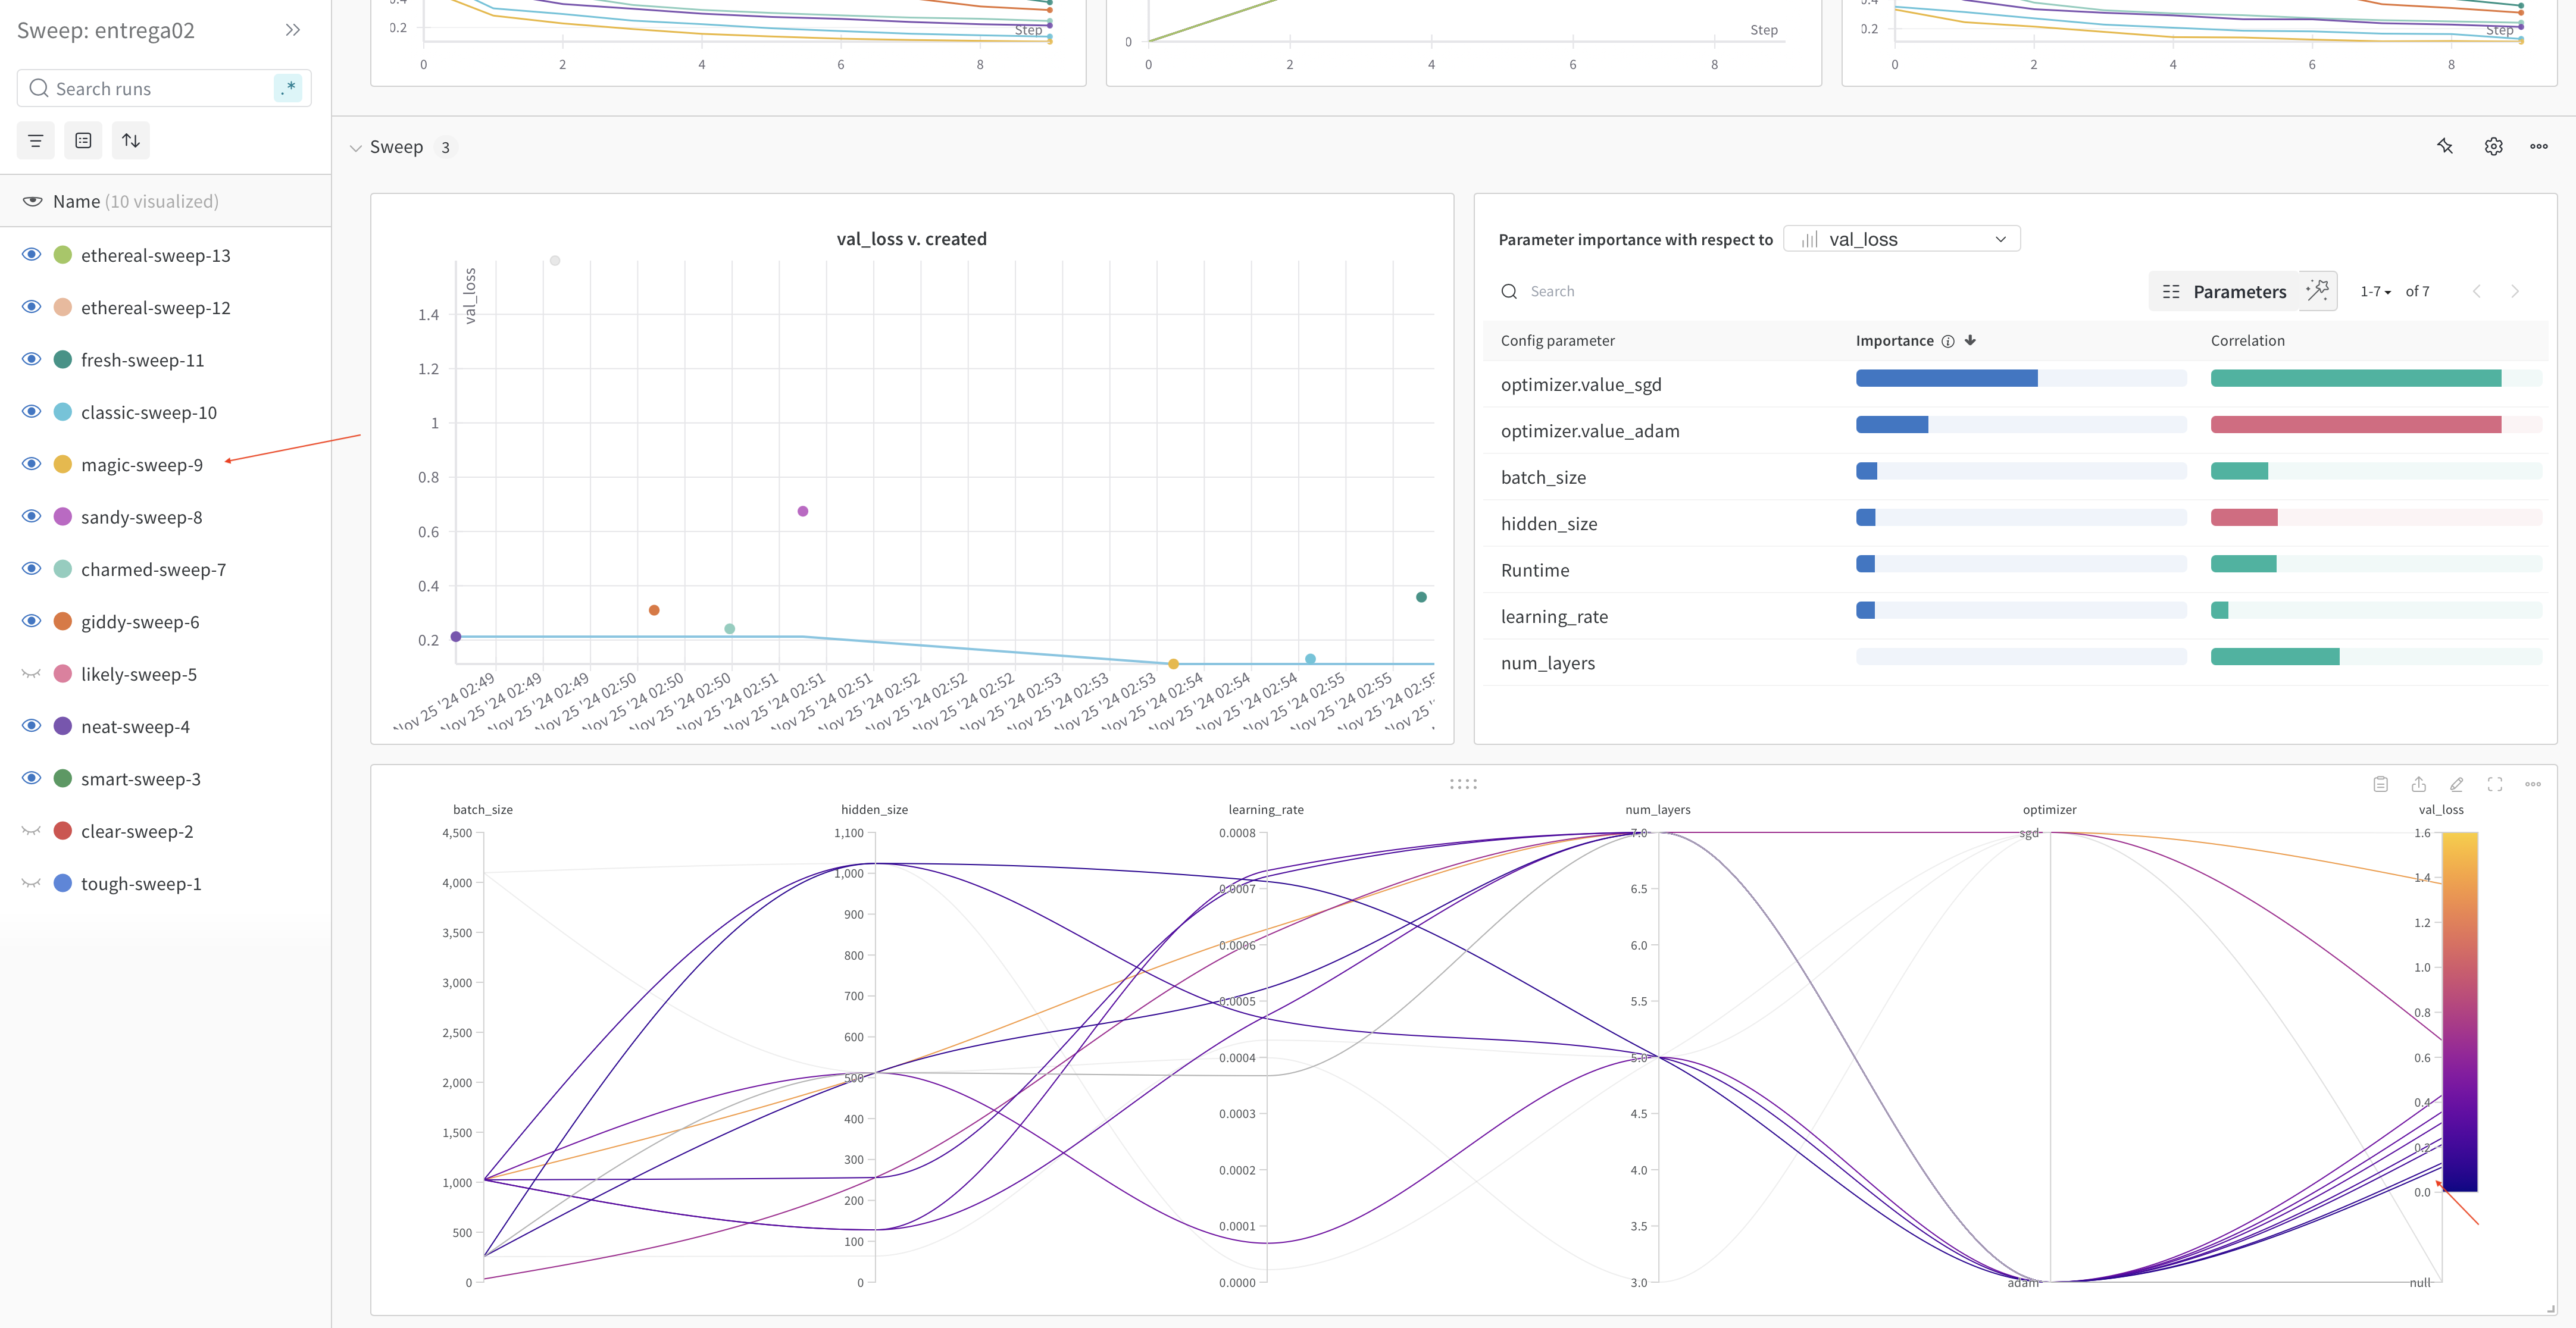

Dicha ejecución, se obtuvo con los siguientes valores:

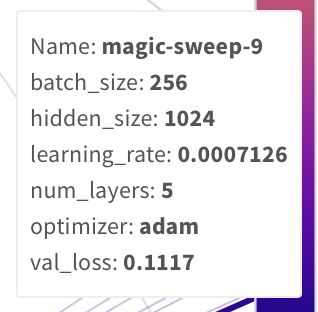

Ejecutemos una nueva predicción, pero ésta vez, con los valores obtenidos de Weight and Biases

In [79]:
BATCH_SIZE=256
HIDDEN_SIZE=1024
NUM_LAYERS=5

model = DynamicRNN(
    INPUT_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    nclasses
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.00007126)

CRITERION = nn.CrossEntropyLoss()

_, _ = train(
    model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader_a,
    val_loader=val_loader_a,
    device=DEVICE,
    do_early_stopping=False,
    epochs=10,
)

Epoch: 001 | Train Loss: 0.97457 | Val Loss: 0.65583
Epoch: 002 | Train Loss: 0.59551 | Val Loss: 0.52581
Epoch: 003 | Train Loss: 0.48645 | Val Loss: 0.44118
Epoch: 004 | Train Loss: 0.42225 | Val Loss: 0.38862
Epoch: 005 | Train Loss: 0.36919 | Val Loss: 0.34126
Epoch: 006 | Train Loss: 0.31918 | Val Loss: 0.28981
Epoch: 007 | Train Loss: 0.27537 | Val Loss: 0.25772
Epoch: 008 | Train Loss: 0.24068 | Val Loss: 0.22568
Epoch: 009 | Train Loss: 0.21301 | Val Loss: 0.19609
Epoch: 010 | Train Loss: 0.18928 | Val Loss: 0.17974


In [80]:
model_calassification_report(model, test_loader_a, DEVICE, nclasses)

Accuracy: 0.9435

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     18118
           1       0.68      0.60      0.64       556
           2       0.90      0.84      0.87      1448
           3       0.24      0.86      0.37       162
           4       0.98      0.91      0.94      1608

    accuracy                           0.94     21892
   macro avg       0.75      0.84      0.76     21892
weighted avg       0.96      0.94      0.95     21892



Si bien los valores no son malos, no se observa notorias mejoras en las métricas.



# Conclusiones

Si bien no se observaron mejoras contundentes en el accuracy del modelo, se observó que realizando data augmentation se lograron mejores valores de f1-score para la clase 3 principalmente. Por lo tanto, se podría concluir que la manipulación de los datos, y el volumen de éstos tiene una incidencia directa sobre modelo, y se propone explorar con un mayor volumen de datos, aplicando diferentes técncias de transformación sobre los datos.